## Import and Explore the Dataset

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
# from google.colab import files
# files.upload()  # Upload your kaggle.json file here

In [ ]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# # reuse the kaggle api

# from google.colab import drive
# drive.mount('/content/drive')

# !mkdir -p ~/.kaggle
# !cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# !kaggle datasets download -d phucthaiv02/butterfly-image-classification -p /content/drive/MyDrive/butterfly_data --unzip


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/butterfly_data/Training_set.csv')

In [ ]:
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6499 entries, 0 to 6498
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  6499 non-null   object
 1   label     6499 non-null   object
dtypes: object(2)
memory usage: 101.7+ KB


In [ ]:
df['label'].value_counts()

,count
label,
MOURNING CLOAK,131
SLEEPY ORANGE,107
ATALA,100
BROWN SIPROETA,99
SCARCE SWALLOW,97
...,...
AMERICAN SNOOT,74
GOLD BANDED,73
MALACHITE,73


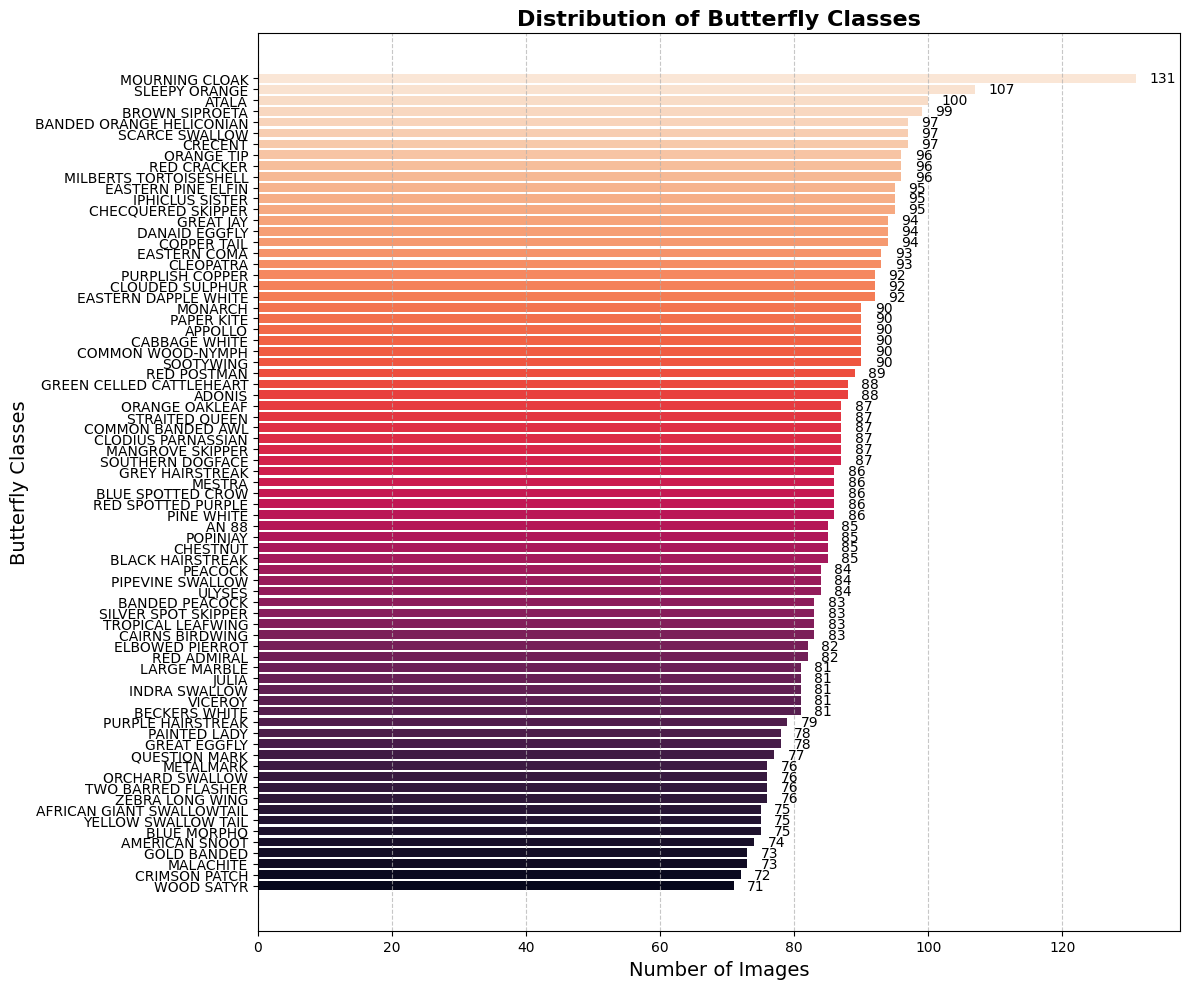

In [ ]:
class_counts = df['label'].value_counts().sort_values(ascending=True)

colors = sns.color_palette("rocket", len(class_counts))

plt.figure(figsize=(12, 10))
bars = plt.barh(class_counts.index, class_counts.values, color=colors)

for bar in bars:
    plt.text(bar.get_width() + 2, bar.get_y() + bar.get_height()/2,
             f'{int(bar.get_width())}', ha='left', va='center', fontsize=10)

# Style customizations
plt.title('Distribution of Butterfly Classes', fontsize=16, fontweight='bold')
plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Butterfly Classes', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()

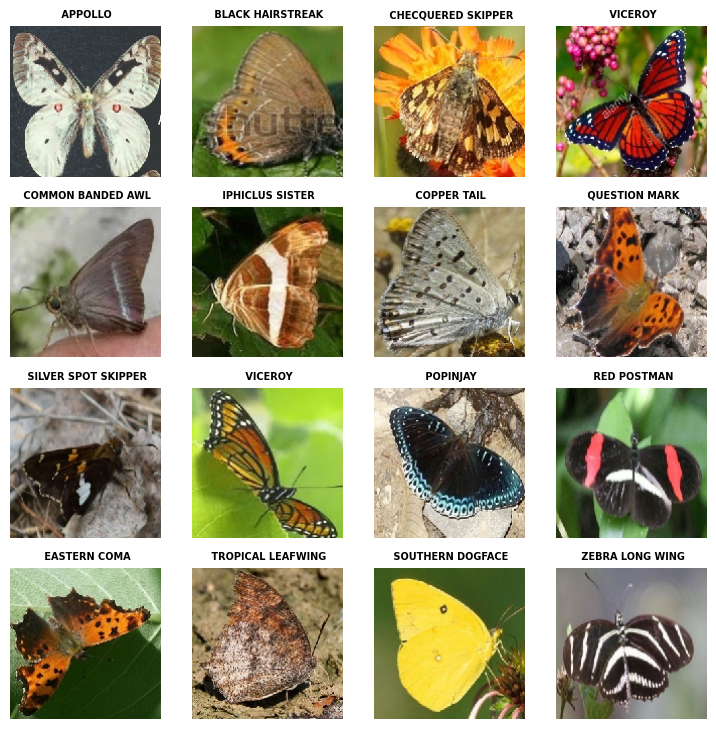

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array


# Define image directory
image_dir = "/content/drive/MyDrive/butterfly_data/train"

# Sample 16 images randomly
sample_images = df.sample(16, random_state=88)

# Create a figure with a stylish layout
fig, axes = plt.subplots(4, 4, figsize=(9, 9))

for i, (index, row) in enumerate(sample_images.iterrows()): # iterates over the rows in the sampled df
    img_path = os.path.join(image_dir, row['filename'])
    img = load_img(img_path, target_size=(150, 150)) # load img and resize
    img_array = img_to_array(img) / 255.0

    ax = axes[i // 4, i % 4]
    ax.imshow(img_array)

    ax.set_title(f" {row['label']}", fontsize=7, fontweight="bold")
    ax.axis('off')

plt.show()

## Preprocessing the Data

-> use if the file structure has a dataset (csv) and train & test folders of imgs
e.g.

* train/
  * img1
  -img2
* test/
  * img1
  -img2

* train.cs
* test.csv

-> where train csv, has a filename and labels

In [ ]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# train data

img_dir = '/content/drive/MyDrive/butterfly_data/train'

train_df, val_df = train_test_split(df, test_size=0.2, random_state=86, stratify=df['label'])

# ImageDataGenerator for data augmentaiton
train_aug = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_aug = ImageDataGenerator(
    rescale=1.0 / 255
)

# Setting up Train and Val Data
train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    directory=img_dir,
    x_col='filename',
    y_col='label',
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

valid_gen = valid_aug.flow_from_dataframe(
    dataframe=val_df,
    directory=img_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [ ]:
print(type(train_gen)), print(type(valid_gen))

<class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>
<class 'keras.src.legacy.preprocessing.image.DataFrameIterator'>


(None, None)

In [ ]:
print("Train samples:", train_gen.samples)
print("Val samples:", valid_gen.samples)

Train samples: 5199
Val samples: 1300


In [ ]:
len(train_gen), len(valid_gen)

(82, 21)

In [ ]:
# no need to use AUTOTUNE :)

# AUTOTUNE = tf.data.AUTOTUNE
# train_gen = train_gen.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# valid_gen = valid_gen.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# # find shape

# for images, label in train_gen:
#   print(images.shape)
#   break

## Creating the Model

In [ ]:
import tensorflow_hub as hub
from tensorflow.keras.applications import MobileNetV2

from keras.losses import CategoricalCrossentropy

In [ ]:
# setup the pretrained model

# feature_model_url = 'https://www.kaggle.com/models/google/mobilenet-v2/TensorFlow2/tf2-preview-feature-vector/4'
# pretrained_model = hub.KerasLayer(feature_model_url, input_shape=(224,224,3), trainable=False)

mobilenet = MobileNetV2(input_shape=(224, 224, 3), include_top=False, pooling='avg', weights='imagenet')
mobilenet.trainable = False

# create the model
inputs = keras.Input(shape=(224,224,3))
x = mobilenet(inputs, training=False)
x = keras.layers.Dense(750, activation='relu')(x)
x = keras.layers.Dense(350, activation='relu')(x)
x = keras.layers.Dense(150, activation='relu')(x)
outputs = keras.layers.Dense(75, activation='softmax')(x)

model = keras.Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss= CategoricalCrossentropy(),
    metrics=['accuracy']
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 750)            │       960,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 350)            │       262,850 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 150)            │        52,650 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 75)             │        11,325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,545,559 (13.53 MB)

 Trainable params: 1,287,575 (4.91 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
history = model.fit(train_gen, epochs=15, validation_data=valid_gen)

Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.1799 - loss: 3.5329 - val_accuracy: 0.6423 - val_loss: 1.3191
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6685 - loss: 1.1737 - val_accuracy: 0.7454 - val_loss: 0.8929
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.7694 - loss: 0.7843 - val_accuracy: 0.7654 - val_loss: 0.7540
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 85s 1s/step - accuracy: 0.8277 - loss: 0.6027 - val_accuracy: 0.8085 - val_loss: 0.6542
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8307 - loss: 0.5318 - val_accuracy: 0.8438 - val_loss: 0.5808
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8506 - loss: 0.4810 - val_accuracy: 0.8323 - val_loss: 0.5779
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.8696 - loss: 0.4062 - val_accuracy: 0.8377 - val_loss: 0.5442
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 84s 1s/step - accuracy: 0.8692 - loss: 0.4054 - val_accuracy: 0.8385 - val_loss

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [ ]:
valid_images, valid_labels = next(valid_gen)

In [ ]:
pred_labels = model.predict(valid_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(valid_labels, axis=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step


In [ ]:
class_indices = valid_gen.class_indices
class_names = {v: k for k, v in class_indices.items()}

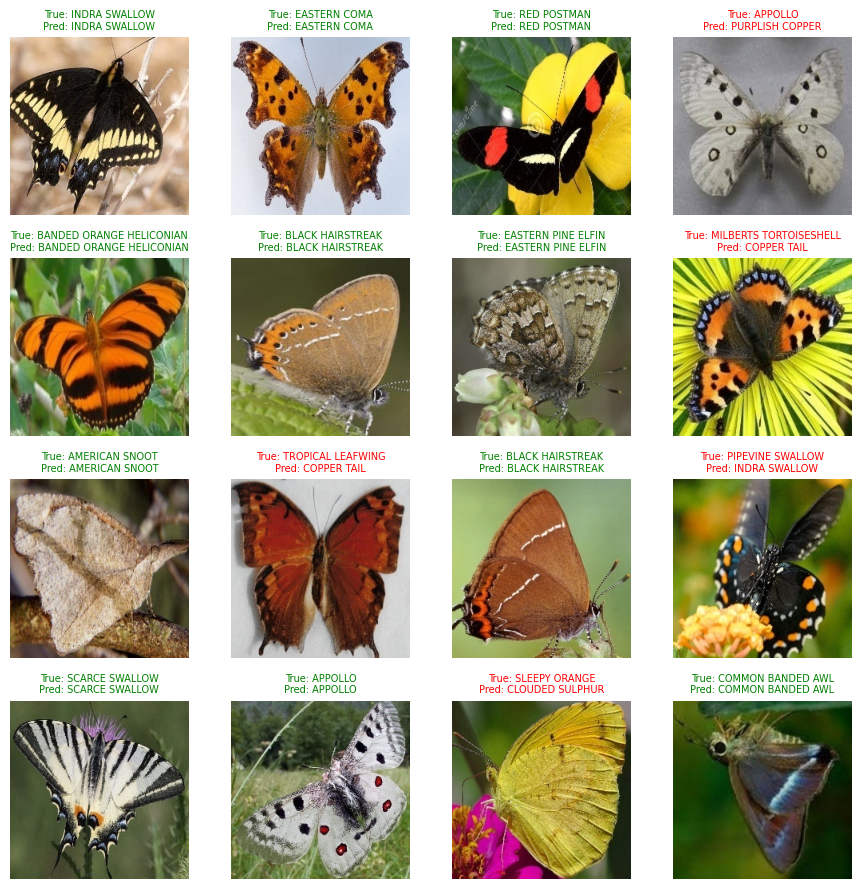

In [ ]:
def display_predictions(images, true_labels, pred_labels, class_names, num_images=16):
    plt.figure(figsize=(9, 9))

    for i in range(num_images):
        ax = plt.subplot(4, 4, i + 1)
        ax.imshow(images[i])

        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]

        # Color-coded titles
        color = "green" if true_label == pred_label else "red"
        ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=7)

        ax.axis("off")

    plt.tight_layout()
    plt.show()

# Call the function
display_predictions(valid_images, true_labels, pred_labels, class_names, num_images=16)

In [ ]:
accuracy = np.mean(true_labels == pred_labels) * 100

# Print accuracy
print(f"Accuracy: {accuracy:.2f}%")

Accuracy: 78.12%


In [ ]:
# save to h5 or keras for keras use
# save_path = '/content/drive/MyDrive/butterfly_modelv5.h5'

# export to SaveModel for TFjs,TFlite,TFserving,etc..
model.export('/content/drive/MyDrive/butterfly_modelv2');

Saved artifact at '/content/drive/MyDrive/butterfly_modelv2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_475')
Output Type:
  TensorSpec(shape=(None, 75), dtype=tf.float32, name=None)
Captures:
  132688637617424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637620496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637623760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637620688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637621072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637622032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637623952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637622608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637622800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132688637620112: TensorSpec(shape=(), dtype=tf.resource

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=tf_saved_model /content/drive/MyDrive/butterfly_modelv2 /content/drive/MyDrive/tfjsv6_model

2025-04-22 09:09:40.918641: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745312980.958163   27816 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745312980.968844   27816 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-22 09:09:50.167339: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1745312990.167559   27816 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
# # export labels

# import pandas as pd
# import json

# a# Load CSV
# df = pd.read_csv('/content/drive/MyDrive/butterfly_data/Training_set.csv')

# # Extract and sort unique labels
# labels = sorted(df['label'].unique().tolist())

# # Save as JSON
# with open('labels.json', 'w') as f:
#     json.dump(labels, f)
